# MNIST Neural Network



## Loading Data

Load MNIST dataset, and split the training images into 80% images to use for training and 20% images to use for validation.  
(N.B. The images are greyscale values ranging from 0.0 to 255.0, so will later need rescaling from 0.0 to 1.0)

In [24]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import pydot

In [2]:
def preprocess(image, label):
    # Cast to float32, normalise, and reshape to (28, 28, 1)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, (28, 28, 1))
    return image, label

batch_size = 10

# Load datasets
train_digits = tfds.load('mnist', split='train[:80%]', shuffle_files=True, as_supervised=True)
val_digits   = tfds.load('mnist', split='train[80%:]', as_supervised=True)
test_digits  = tfds.load('mnist', split='test', as_supervised=True)

# Apply preprocessing and batching
train_digits = train_digits.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_digits   = val_digits.map(preprocess).batch(batch_size)
test_digits  = test_digits.map(preprocess).batch(batch_size)

## Create CNN

Create Convolutional Neural Network model to train on MNIST data.

In [25]:
input_shape = (28, 28, 1)
input = tf.keras.Input(shape=(28, 28, 1))
regularizer = tf.keras.regularizers.L2(0.005)

# Expansion layer, to increase channels from 1 to 32
E1 = tf.keras.layers.Conv2D(32, (1, 1), strides=1, padding='same', activity_regularizer=regularizer)(input)
# SeparableConv2d layer, with 8 5x5 filters and stride 1, compress channels to 8
Z1 = tf.keras.layers.SeparableConv2D(8, (5, 5), strides=1, padding='same', activity_regularizer=regularizer)(E1)
# ReLU
A1 = tf.keras.layers.ReLU()(Z1)
# Expansion layer, to increase channels from 1 to 32
E2 = tf.keras.layers.Conv2D(32, (1, 1), strides=1, padding='same', activity_regularizer=regularizer)(A1)
# SeparableConv2d layer, with 8 5x5 filters and stride 1, compress channels to 8
Z2 = tf.keras.layers.SeparableConv2D(8, (5, 5), strides=1, padding='same', activity_regularizer=regularizer)(E2)
# Skip connection
A2 = tf.keras.layers.Add()([Z2, A1])
# ReLU
A2 = tf.keras.layers.ReLU()(A2)
# Max pooling
P1 = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(A2)
# Expansion layer, to increase channels from 8 to 32
E3 = tf.keras.layers.Conv2D(32, (1, 1), strides=1, padding='same', activity_regularizer=regularizer)(P1)
# SeparableConv2d layer, with 8 5x5 filters and stride 1
Z3 = tf.keras.layers.SeparableConv2D(8, (5, 5), strides=1, padding='same', activity_regularizer=regularizer)(E3)
# Skip connection
A3 = tf.keras.layers.Add()([Z3, P1])
# ReLU
A3 = tf.keras.layers.ReLU()(A3)
# Expansion layer, to increase channels from 8 to 32
E4 = tf.keras.layers.Conv2D(32, (1, 1), strides=1, padding='same', activity_regularizer=regularizer)(A3)
# SeparableConv2d layer, with 8 5x5 filters and stride 1
Z4 = tf.keras.layers.SeparableConv2D(8, (5, 5), strides=1, padding='same', activity_regularizer=regularizer)(E4)
# Skip connection
A4 = tf.keras.layers.Add()([Z4, A3])
# ReLU
A4 = tf.keras.layers.ReLU()(A4)
# Expansion layer, to increase channels from 8 to 32
E5 = tf.keras.layers.Conv2D(32, (1, 1), strides=1, padding='same', activity_regularizer=regularizer)(A4)
# SeparableConv2d layer, with 8 5x5 filters and stride 1
Z5 = tf.keras.layers.SeparableConv2D(8, (5, 5), strides=1, padding='same', activity_regularizer=regularizer)(E5)
# Skip connection
A5 = tf.keras.layers.Add()([Z5, A4])
# ReLU
A5 = tf.keras.layers.ReLU()(A5)
# Max pooling window 2x2, stride 2
P2 = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(A5)
# Flatten
F = tf.keras.layers.Flatten()(P2)
FD = tf.keras.layers.Dropout(0.4)(F)
# dense layer, 80 nodes
D1 = tf.keras.layers.Dense(120, activation='relu', activity_regularizer=regularizer)(FD)
D1D = tf.keras.layers.Dropout(0.4)(D1)
# output layer
output = tf.keras.layers.Dense(10, activation='softmax')(D1D)

model = tf.keras.Model(inputs=input, outputs=output)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
tf.keras.utils.plot_model(model, "model_plot.png", show_shapes=True)

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 28, 28,    │         64 │ input_layer_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_38 │ (None, 28, 28, 8) │      1,064 │ conv2d_41[0][0]   │
│ (SeparableConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_44 (ReLU)     │ (None, 28, 28, 8) │          0 │ separable_conv2d… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 28, 28,    │        288 │ re_lu_44[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_39 │ (None, 28, 28, 8) │      1,064 │ conv2d_42[0][0]   │
│ (SeparableConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 28, 28, 8) │          0 │ separable_conv2d… │
│                     │                   │            │ re_lu_44[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_45 (ReLU)     │ (None, 28, 28, 8) │          0 │ add_15[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 14, 14, 8) │          0 │ re_lu_45[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 14, 14,    │        288 │ max_pooling2d_18… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_40 │ (None, 14, 14, 8) │      1,064 │ conv2d_43[0][0]   │
│ (SeparableConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 14, 14, 8) │          0 │ separable_conv2d… │
│                     │                   │            │ max_pooling2d_18… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_46 (ReLU)     │ (None, 14, 14, 8) │          0 │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 14, 14,    │        288 │ re_lu_46[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_41 │ (None, 14, 14, 8) │      1,064 │ conv2d_44[0][0]   │
│ (SeparableConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 14, 14, 8) │          0 │ separable_conv2d… │
│                     │                   │            │ re_lu_46[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_47 (ReLU)     │ (None, 14, 14, 8) │          0 │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 14, 14,    │        288 │ re_lu_47[0][0]    │
│                     │ 32)               │            │                 

 Total params: 54,906 (214.48 KB)

 Trainable params: 54,906 (214.48 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## Train Model

Train the model on the training data, and use validation data to track accuracy and progress

In [18]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.8

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_digits, epochs=20, validation_data=val_digits, callbacks=[callback])

Epoch 1/20
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 184s 37ms/step - accuracy: 0.8792 - loss: 0.8800 - val_accuracy: 0.9651 - val_loss: 0.2934 - learning_rate: 0.0010
Epoch 2/20
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 183s 38ms/step - accuracy: 0.9468 - loss: 0.3385 - val_accuracy: 0.9730 - val_loss: 0.2345 - learning_rate: 0.0010
Epoch 3/20
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 229s 44ms/step - accuracy: 0.9526 - loss: 0.2854 - val_accuracy: 0.9772 - val_loss: 0.2071 - learning_rate: 0.0010
Epoch 4/20
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 238s 39ms/step - accuracy: 0.9567 - loss: 0.2594 - val_accuracy: 0.9777 - val_loss: 0.1747 - learning_rate: 0.0010
Epoch 5/20
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 190s 40ms/step - accuracy: 0.9577 - loss: 0.2479 - val_accuracy: 0.9793 - val_loss: 0.2109 - learning_rate: 0.0010
Epoch 6/20
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 195s 41ms/step - accuracy: 0.9625 - loss: 0.2175 - val_accuracy: 0.9781 - val_loss: 0.1668 - learning_rate: 8.0000e-04
Epoch 7/20
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 341s 71ms/st

### View Training History

C:\Users\User\AppData\Local\Temp\ipykernel_10416\1989446866.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss': 'Training', 'val_loss': 'Validation'}, inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_10416\1989446866.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy': 'Training', 'val_accuracy': 'Validation'}, inplace=True)


<Axes: title={'center': 'Model Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>

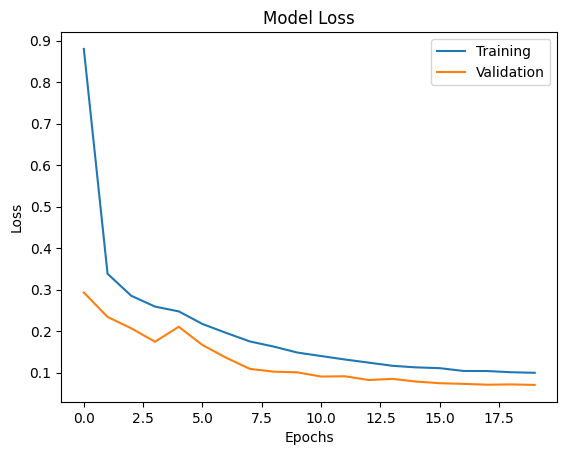

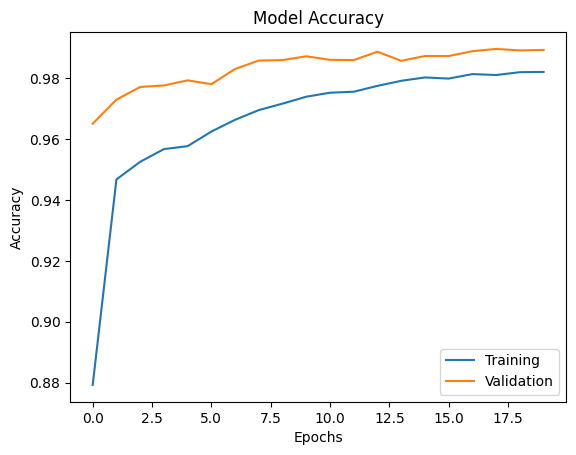

In [19]:
df_loss_acc = pd.DataFrame(history.history)
df_loss = df_loss_acc[['loss', 'val_loss']]
df_loss.rename(columns={'loss': 'Training', 'val_loss': 'Validation'}, inplace=True)

df_acc = df_loss_acc[['accuracy', 'val_accuracy']]
df_acc.rename(columns={'accuracy': 'Training', 'val_accuracy': 'Validation'}, inplace=True)

df_loss.plot(title='Model Loss', ylabel='Loss', xlabel='Epochs')
df_acc.plot(title='Model Accuracy', ylabel='Accuracy', xlabel='Epochs')

# Test Model

Test the model on test data.

In [20]:
model.evaluate(test_digits)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9901 - loss: 0.0651


[0.06506606191396713, 0.9901000261306763]

### (Optional) Save Model

Save model weights, biases and structure so it can later be loaded and recreated.

In [21]:

model.save('mnist_res_net_99.01.keras')